## IMPORTS and Hyperparameters

In [1]:
import os
import numpy as np
import cv2
from glob import glob
import imagesize
import pandas as pd
import scipy.io as sio
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, CSVLogger
from keras.layers import Dense, GlobalAveragePooling2D, Flatten, Dropout
from keras.applications import NASNetMobile, VGG16
from tensorflow.keras.optimizers import Adam

In [42]:
global image_h, image_w, image_c, input_shape, batch_size, lr, epochs, seed, load_norm_csv, shuffle, reshuffle_each_iteration
global classes
'''---HyparParameters---'''
image_h = 300
image_w = 300
image_c = 3
input_shape = (image_h, image_w, image_c)
#############
batch_size = 16
lr = 1e-3
epochs = 30
val_size = 0.2
#############
shuffle = True
seed = 42
reshuffle_each_iteration = True
tf.random.set_seed(seed)
np.random.seed(seed)

'''---Paths---'''
# dataset_path = '/content/drive/MyDrive/DataSets/CALTECH'
results_path = '/content/drive/MyDrive/DataSets/Classification_with_localization/results'
images_path = '/content/drive/MyDrive/DataSets/CALTECH/CALTECH_Dataset'
annotations_path = '/content/drive/MyDrive/DataSets/CALTECH/CALTECH_Annotations'

classes = ['butterfly', 'cougar_face', 'elephant']

## Helper_functions

In [3]:
def data_pipeline(input:tuple, parse_function, batch_size, shuffle, seed, reshuffle_each_iteration):
  with tf.device('/cpu:0'):
    data_set = tf.data.Dataset.from_tensor_slices(input)
    if shuffle:
      data_set = data_set.shuffle(len(input[0]), seed=seed, reshuffle_each_iteration=reshuffle_each_iteration)
    data_set = data_set.map(parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    data_set = data_set.map(fixup_shape)
    data_set = data_set.batch(batch_size)
    data_set = data_set.prefetch(tf.data.experimental.AUTOTUNE)
  return data_set


def parse_function(file_path, anno_path):
  target = {}
  def _parse_function(file_path, anno_path):
    ## image preprocessing
    image_string = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image_string, channels=image_c)
    image = tf.image.convert_image_dtype(image, tf.float32)
    h, w, c = image.shape
    old_size = np.array([h, h, w, w]).astype(np.float32)
    image = tf.image.resize(image, [image_h, image_w])

    mat_contents = sio.loadmat(anno_path)
    mat_contents = mat_contents['box_coord'][0] # y1,y2,x1,x2
    mat_contents = mat_contents/old_size
    label = classes.index(tf.strings.split(file_path, '/')[-2])
    label = tf.one_hot(label, len(classes), dtype=tf.int16)
    return image, label, mat_contents

  ## annotation preprocessing
  image, label, anno = tf.numpy_function(_parse_function, [file_path, anno_path], [tf.float32, tf.int16, tf.float32])
  target["boxes"] = anno
  target["labels"] = label
  return image, target


def fixup_shape(images, target):
    images.set_shape([image_h, image_w, image_c])
    target["boxes"].set_shape([4])
    target["labels"].set_shape([len(classes)])
    return images, target

In [4]:
def c_callbacks(outdir, name='cnn'):
    checkpoint_cb = ModelCheckpoint(outdir+"/"+name+".keras", monitor='val_loss',
                                    verbose=1, save_best_only=True, mode='min',
                                    save_weights_only=False, save_freq='epoch')

    rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1)

    early_stopping_cb = EarlyStopping(monitor="val_loss", min_delta=0, patience=10,
                                      verbose=1, mode="min", baseline=None,
                                      start_from_epoch=0, restore_best_weights=True)

    logger_cb = CSVLogger(outdir+"/"+name+"_log.csv", separator=",", append=False)

    return [checkpoint_cb, rlrop, early_stopping_cb, logger_cb]

## DataPipeLine

In [5]:
img_list = sorted(glob(images_path+'/*/*.jpg'))
anno_list = sorted(glob(annotations_path+'/*/*.mat'))
len(img_list), len(anno_list)

(218, 218)

In [6]:
from sklearn.model_selection import train_test_split

train_img_list, val_img_list, train_anno_list, val_anno_list = train_test_split(img_list, anno_list, test_size=val_size, random_state=seed, shuffle=True, stratify=None)
len(train_img_list), len(val_img_list), len(train_anno_list), len(val_anno_list)

(174, 44, 174, 44)

In [7]:
training_set = data_pipeline((train_img_list, train_anno_list), parse_function, batch_size, shuffle, seed, reshuffle_each_iteration)
validation_set = data_pipeline((val_img_list, val_anno_list), parse_function, batch_size, shuffle, seed, reshuffle_each_iteration)

## Little bit Training visualization

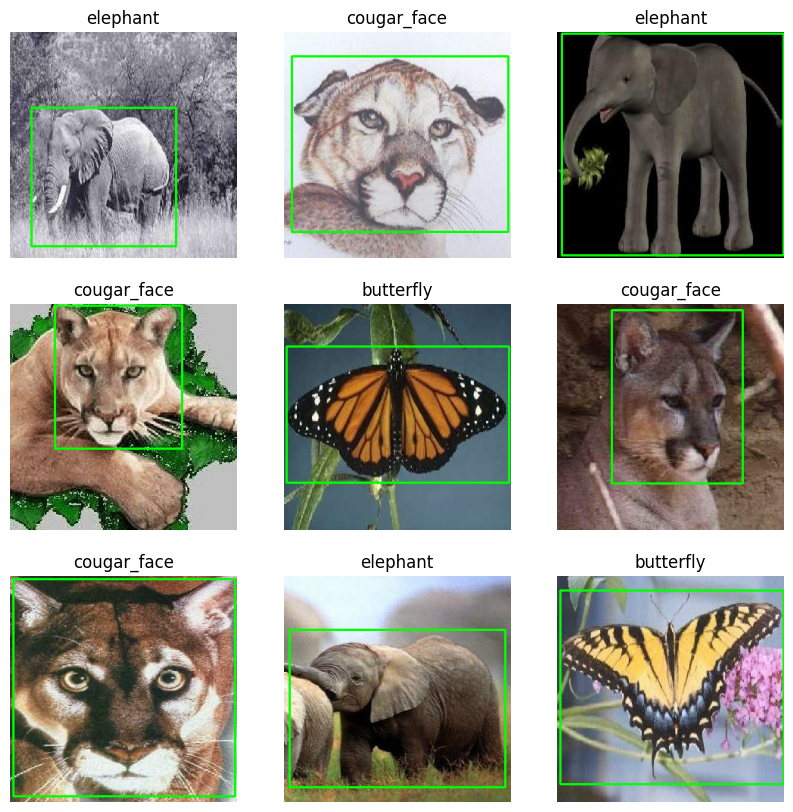

In [8]:
needed = 9
cols = 3
m = int(np.ceil(needed/cols))
fig, axs = plt.subplots(m,cols, figsize=(10,10))
axs = axs.ravel()
for (x,dct),(ax) in  zip(training_set.unbatch().take(needed), axs):
  y, z = dct['labels'], dct['boxes']
  img = cv2.rectangle(x.numpy(), (int(z[2]*image_w),int(z[0]*image_h)), (int(z[3]*image_w),int(z[1]*image_h)), (0,1,0),2)
  ax.imshow(img)
  ax.set_title(classes[tf.argmax(y)])
  ax.axis('off')


## Model Build and Training
- NASNET as base model

In [ ]:
num_classes = len(classes)

N_model = NASNetMobile(input_shape=(300,300,3), include_top=False, weights='imagenet')
N_model.trainable = False

base_out = N_model(N_model.input, training=False)
x = GlobalAveragePooling2D()(base_out)
x = Flatten()(x)

bboxHead = Dense(256, activation="relu")(x)
bboxHead = Dense(128, activation="relu")(bboxHead)
bboxHead = Dropout(0.2)(bboxHead)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dropout(0.2)(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4, activation='relu', name= "boxes")(bboxHead)

classHead = Dense(256, activation="relu")(x)
classHead = Dense(128, activation="relu")(classHead)
classHead = Dropout(0.2)(classHead)
classHead = Dense(64, activation="relu")(classHead)
classHead = Dropout(0.2)(classHead)
classHead = Dense(32, activation="relu")(classHead)
classHead = Dense(num_classes, activation='softmax',name="labels")(classHead)

nasnet_model = tf.keras.models.Model(inputs=N_model.input, outputs=(bboxHead, classHead))

19993432/19993432 [==============================] - 1s 0us/step


In [ ]:
name='NasNet_base'


nasnet_model.compile(
  optimizer=Adam(learning_rate=lr),
  loss={
    "boxes": "mean_squared_error",
    "labels": "categorical_crossentropy"
    },
  metrics={'labels': 'accuracy'})

H_nas = nasnet_model.fit(
    training_set,
    validation_data=validation_set, batch_size=batch_size,
    epochs=epochs ,verbose=1, callbacks=c_callbacks(outdir=results_path, name=name))

Epoch 1/30
6/6 [==============================] - ETA: 0s - loss: 1.0532 - boxes_loss: 0.1972 - labels_loss: 0.8561 - labels_accuracy: 0.6954 
Epoch 1: val_loss improved from inf to 0.39573, saving model to /content/drive/MyDrive/DataSets/CALTECH/results/NasNet_base.keras
6/6 [==============================] - 153s 23s/step - loss: 1.0532 - boxes_loss: 0.1972 - labels_loss: 0.8561 - labels_accuracy: 0.6954 - val_loss: 0.3957 - val_boxes_loss: 0.0325 - val_labels_loss: 0.3632 - val_labels_accuracy: 0.9318 - lr: 0.0010
Epoch 2/30
6/6 [==============================] - ETA: 0s - loss: 0.3855 - boxes_loss: 0.0913 - labels_loss: 0.2942 - labels_accuracy: 0.9425
Epoch 2: val_loss improved from 0.39573 to 0.15846, saving model to /content/drive/MyDrive/DataSets/CALTECH/results/NasNet_base.keras
6/6 [==============================] - 40s 7s/step - loss: 0.3855 - boxes_loss: 0.0913 - labels_loss: 0.2942 - labels_accuracy: 0.9425 - val_loss: 0.1585 - val_boxes_loss: 0.0527 - val_labels_loss: 0.1

## plot performance

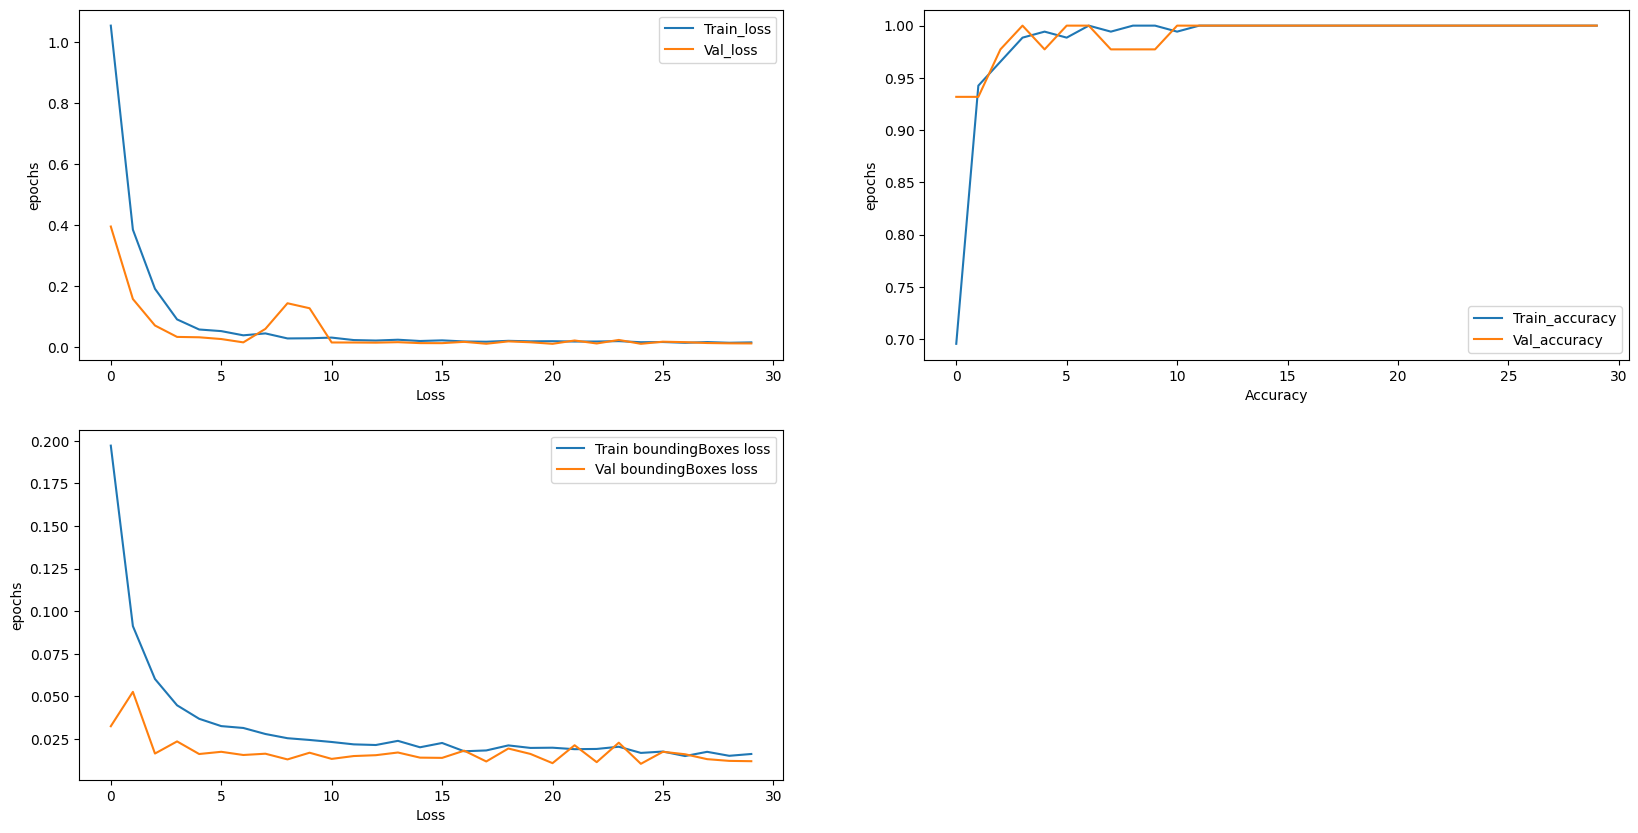

In [ ]:
## plot performance

hist1 = pd.read_csv(os.path.join(results_path, name+'_log.csv'))

plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
plt.plot(hist1['epoch'], hist1['loss'], label='Train_loss')
plt.plot(hist1['epoch'], hist1['val_loss'], label='Val_loss')
plt.xlabel('Loss')
plt.ylabel('epochs')
plt.legend()
plt.subplot(2,2,2)
plt.plot(hist1['epoch'], hist1['labels_accuracy'], label='Train_accuracy')
plt.plot(hist1['epoch'], hist1['val_labels_accuracy'], label='Val_accuracy')
plt.xlabel('Accuracy')
plt.ylabel('epochs')
plt.legend()
plt.subplot(2,2,3)
plt.plot(hist1['epoch'], hist1['boxes_loss'], label='Train boundingBoxes loss')
plt.plot(hist1['epoch'], hist1['val_boxes_loss'], label='Val boundingBoxes loss')
plt.xlabel('Loss')
plt.ylabel('epochs')
plt.legend()
plt.show()

## visualize performance on validation set

In [ ]:
nasnet_model = tf.keras.saving.load_model(results_path + '/NasNet_base.keras')

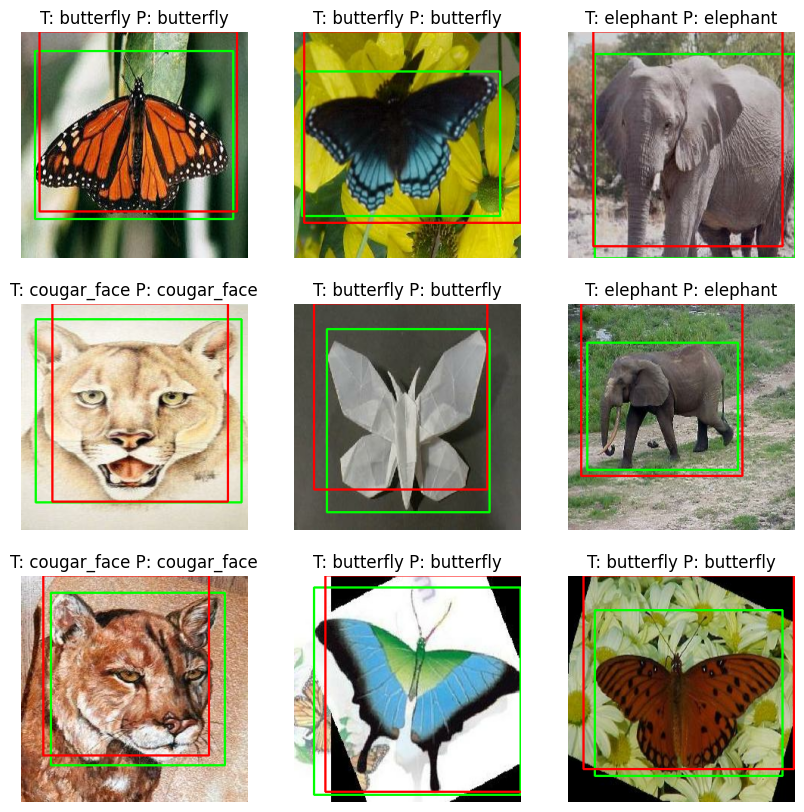

In [41]:
## visualize performance on validation set
needed = 9
cols = 3
m = int(np.ceil(needed/cols))
fig, axs = plt.subplots(m,cols, figsize=(10,10))
axs = axs.ravel()
for (x,dct),(ax) in  zip(validation_set.unbatch().take(needed), axs):

  hh = nasnet_model.predict(np.expand_dims(x, axis=0), verbose=0)
  z_hat = hh[0].ravel()
  y_hat = hh[1].ravel()

  y, z = dct['labels'], dct['boxes']
  img = cv2.rectangle(x.numpy(), (int(z[2]*image_w),int(z[0]*image_h)), (int(z[3]*image_w),int(z[1]*image_h)), (0,1,0),2)
  img = cv2.rectangle(img, (int(z_hat[2]*image_w),int(z_hat[0]*image_h)), (int(z_hat[3]*image_w),int(z_hat[1]*image_h)), (1,0,0),2)
  ax.imshow(img)
  ax.set_title('T: '+classes[tf.argmax(y)]+' P: '+classes[tf.argmax(y_hat)])
  ax.axis('off')

## visualize performance on custom set

In [47]:
def parse_function_custom(file_path):
  ## image preprocessing
  image_string = tf.io.read_file(file_path)
  image = tf.image.decode_jpeg(image_string, channels=image_c)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, [image_h, image_w])

  return image

In [78]:
## visualize performance on custom set
custom_dir = '/content/drive/MyDrive/DataSets/Classification_with_localization/custom'
img_list = sorted(glob(custom_dir+'/*/*.jpg'))
with tf.device('/cpu:0'):
  custom_set = tf.data.Dataset.from_tensor_slices(img_list)
  custom_set = custom_set.map(parse_function_custom, num_parallel_calls=tf.data.experimental.AUTOTUNE)


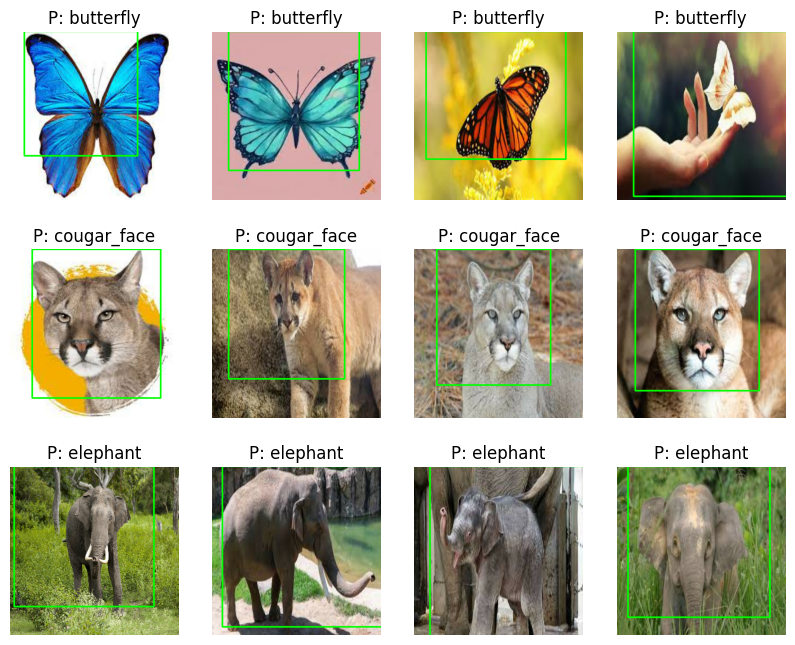

In [85]:
needed = 12
cols = 4
m = int(np.ceil(needed/cols))
fig, axs = plt.subplots(m,cols, figsize=(10,8))
axs = axs.ravel()
for (x),(ax) in  zip(custom_set.take(needed), axs):

  hh = nasnet_model.predict(np.expand_dims(x, axis=0), verbose=0)
  z_hat = hh[0].ravel()
  y_hat = hh[1].ravel()

  img = cv2.rectangle(x.numpy(), (int(z_hat[2]*image_w),int(z_hat[0]*image_h)), (int(z_hat[3]*image_w),int(z_hat[1]*image_h)), (0,1,0),2)
  ax.imshow(img)
  ax.set_title('P: '+classes[tf.argmax(y_hat)])
  ax.axis('off')

In [ ]:
## Agumentation needed